In [1]:
!pip install contractions
!pip install beautifulsoup4

In [2]:
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!gdown 1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy

Downloading...
From: https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:02<00:00, 22.7MB/s]


In [4]:
df = pd.read_csv("IMDB-Dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.duplicated().sum()

418

In [9]:
df.drop_duplicates()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [10]:
stop = set(stopwords.words('english'))

In [11]:
# Expanding contractions
def expand_contractions(text):
  return contractions.fix(text)

# Function to clean data
def preprocess_text(text):

  wl = WordNetLemmatizer()

  soup = BeautifulSoup(text, "html.parser") # Removing html tags
  text = soup.get_text()
  text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
  emoji_clean = re.compile ("["
                            u"\U0001F600-\U0001F64F " # emoticons
                            u"\U0001F300-\U0001F5FF " # symbols & pictographs
                            u"\U0001F680-\U0001F6FF " # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF " # flags (iOS)
                            u"\U00002702-\U000027B0 "
                            u"\U000024C2-\U0001F251 "
                            "]+", flags=re.UNICODE )
  text = emoji_clean.sub(r'', text)
  text = re.sub(r'\.(?=\S)', '. ',text ) #add space after full stop
  text = re.sub(r'http\S+', '', text ) # remove urls
  text = "".join([ word.lower() for word in text if word not in string.punctuation  ]) # remove punctuation and make text lowercase
  text = " ".join([ wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha() ]) # lemmatize
  return text

In [12]:
df['review'] = df['review'].apply(preprocess_text)

<ipython-input-11-f64300fb5b1c>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") # Removing html tags


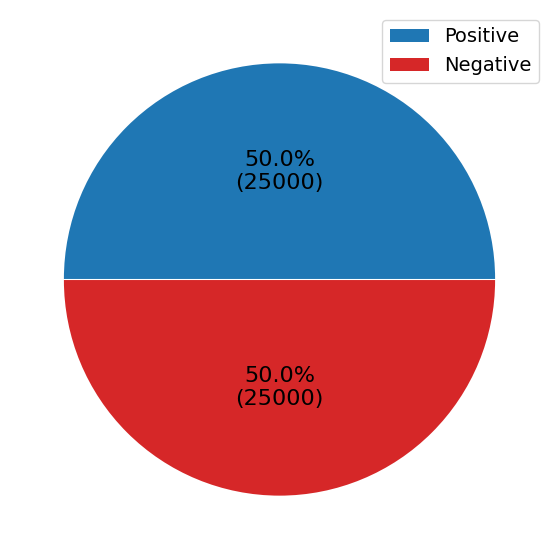

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Creating autocpt arguments
def func(pct, allvalues):
  absolute = int( pct/100.* np.sum(allvalues) )
  return "{:.1f}%\n({:d})".format(pct , absolute )

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [ freq_pos , freq_neg ]

labels = ['positive', 'negative']

# Create pie chart
pie , ax = plt.subplots(figsize =[11 ,7])

plt.pie(x=data, \
        autopct = lambda pct: func(pct , data), \
        explode = [0.0025]*2, \
        pctdistance = 0.5, \
        colors = [ sns.color_palette()[0], 'tab:red'], \
        textprops = {'fontsize': 16}
      )

# plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
labels = [r'Positive', r'Negative']
plt.legend(labels , loc ="best", prop ={ 'size': 14})
pie.savefig("PieChart.png")
plt.show()

In [14]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

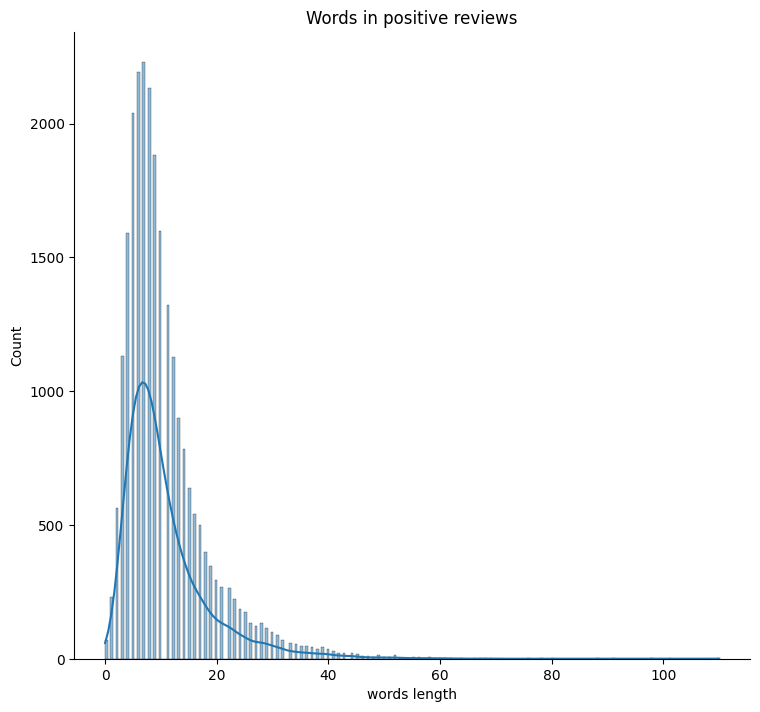

In [15]:
hist_positive = sns.displot(
  data=df_temp[df_temp['sentiment'] == 'positive'],
  x="words length",
  hue="sentiment",
  kde=True,
  height =7,
  aspect=1.1,
  legend=False
).set(title='Words in positive reviews')

plt.show(hist_positive)

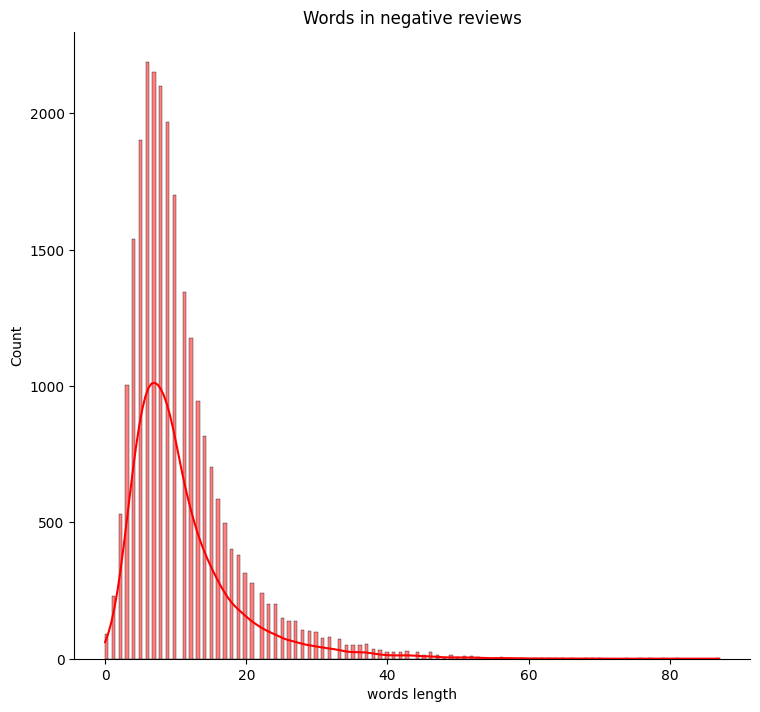

In [16]:
hist_negative = sns.displot(
  data=df_temp[df_temp['sentiment'] == 'negative'],
  x="words length",
  hue="sentiment",
  kde=True,
  height =7,
  aspect=1.1,
  legend=False,
  palette =['red']
).set(title ='Words in negative reviews')

plt.show(hist_negative)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [19]:
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df['review']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size =0.2 , random_state =42)

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [22]:
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train )
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test )

0.569

In [23]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train )
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.57